In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/soccer/database.sqlite


Le but de cette expérience est de vérifier empiriquement la validité de la pythagorean expectation dans le cas du football européen dans le cadre du MOOC "Foundations of sports analytics: Data, representation and models in sports" de l'université du Michigan.
Avancée par Bill James dans le cadre du baseball pour prédire le nombre de points qu'une équipe devrait gagner en fonction de son nombre de points marqués et encaissés, elle peut être adaptée au football par l'énoncé suivant : le pourcentage de victoires est proportionnel au quotient du carré du nombre de buts marqués par la somme du nombre de buts marqués et du nombre de buts encaissés. 
L'équation donne : 
$\newline winratio ~ \alpha ~ \frac{scored^2}{scored^2+allowed^2} \newline$
Nous allons tenter de vérifier si cette relation est plus forte si on considère le pourcentage de victoires ou le nombre de points gagnés par match en moyenne.

In [2]:
database = '../input/soccer/database.sqlite'
conn = sqlite3.connect(database)
tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)

In [3]:
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [4]:
Player_Attributes = pd.read_sql("""SELECT * 
                        FROM Player_Attributes
                        """, conn)
Player = pd.read_sql("""SELECT * 
                        FROM Player
                        """, conn)
Match = pd.read_sql("""SELECT * 
                        FROM Match
                        """, conn)
League = pd.read_sql("""SELECT * 
                        FROM League
                        """, conn)
Country = pd.read_sql("""SELECT * 
                        FROM Country
                        """, conn)
Team = pd.read_sql("""SELECT * 
                        FROM Team
                        """, conn)
Team_Attributes = pd.read_sql("""SELECT * 
                        FROM Team_Attributes
                        """, conn)

# Victoire à un point

In [5]:
df0=Match[['id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']]

In [9]:
df0['home_team_goal']

0        1
1        0
2        0
3        5
4        1
        ..
25974    1
25975    1
25976    2
25977    0
25978    4
Name: home_team_goal, Length: 25979, dtype: int64

In [13]:
df0['home_res'] = np.where(df0['home_team_goal']>df0['away_team_goal'],1,0)
df0['away_res'] = np.where(df0['away_team_goal']>df0['home_team_goal'],1,0)
df0['count']=1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [14]:
df0.head()

,id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_res,away_res,count
0,1,9987,9993,1,1,0,0,1
1,2,10000,9994,0,0,0,0,1
2,3,9984,8635,0,3,0,1,1
3,4,9991,9998,5,0,1,0,1
4,5,7947,9985,1,3,0,1,1


In [15]:
df_home0 = df0.groupby(['home_team_api_id']).sum()[['home_team_goal', 'away_team_goal', 'home_res', 'count']]
df_home0.columns = ['team_home_goals', 'opp_home_goals', 'res_home', 'games_home']

In [16]:
df_away0 = df0.groupby(['away_team_api_id']).sum()[['home_team_goal', 'away_team_goal', 'away_res', 'count']]
df_away0.columns = ['opp_away_goals', 'team_away_goals', 'res_away', 'games_away']

In [17]:
df_all0 = pd.concat([df_home0, df_away0], axis=1, join='inner')

In [18]:
df_all0.head()

,team_home_goals,opp_home_goals,res_home,games_home,opp_away_goals,team_away_goals,res_away,games_away
1601,148,123,54,120,169,132,38,120
1773,74,73,16,45,89,52,6,45
1957,176,123,63,120,192,111,24,120
2033,70,92,19,75,117,68,13,75
2182,215,91,74,120,119,157,50,120


In [19]:
df_all0['gA'] = df_all0['opp_home_goals'] + df_all0['opp_away_goals']
df_all0['gF'] = df_all0['team_home_goals'] + df_all0['team_away_goals']
df_all0['res_all'] = df_all0['res_home'] + df_all0['res_away']
df_all0['games'] = df_all0['games_home'] + df_all0['games_away']
df_all0['win_pcg'] = df_all0['res_all']/df_all0['games']

In [20]:
df_res0 = df_all0[['gA', 'gF', 'win_pcg']]

In [21]:
df_res0['pred'] = df_res0['gF']**2/(df_res0['gF']**2+df_res0['gA']**2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
df_res0.head()

,gA,gF,win_pcg,pred
1601,292,280,0.383333,0.479030
1773,162,126,0.244444,0.376923
1957,315,287,0.362500,0.453589
2033,209,138,0.213333,0.303611
2182,210,372,0.516667,0.758335


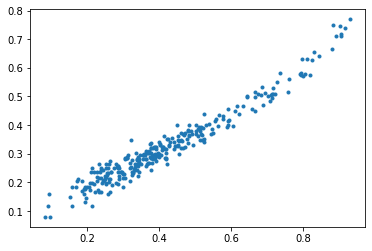

In [23]:
plt.plot(df_res0['pred'], df_res0['win_pcg'], '.')

Visuellement, la corrélation entre nos prédictions et le pourcentage de victoires réel est directe.

In [25]:
pyth_lm0 = smf.ols(formula='win_pcg ~ pred', data=df_res0).fit()
pyth_lm0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                win_pcg   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     5289.
Date:                Tue, 06 Dec 2022   Prob (F-statistic):          2.75e-191
Time:                        23:26:59   Log-Likelihood:                 631.13
No. Observations:                 299   AIC:                            -1258.
Df Residuals:                     297   BIC:                            -1251.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0379      0.004      8.808      0.000       0.029       0.046
pred           0.6870      0.009     72.724      0.000       0.668       0.706
==============================================================================
Omnibus:                       11.179   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.411
Skew:                           0.437   Prob(JB):                      0.00333
Kurtosis:                       3.390   Cond. No.                         6.56
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

On obtient effectivement un fort coefficient de détermination R² = 0,947 et une p-value très faible qui semblent confirmer l'hypothèse de la pythagorean expectation.

# **Victoire à trois points**

In [18]:
df2=Match[['id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']]

In [19]:
df2['home_res'] = np.where(df2['home_team_goal']>df2['away_team_goal'],3,0) + np.where(df2['home_team_goal']==df2['away_team_goal'],1,0)
df2['away_res'] = np.where(df2['away_team_goal']>df2['home_team_goal'],3,0) + np.where(df2['away_team_goal']==df2['home_team_goal'],1,0)
df2['count']=1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [20]:
df2.head()

,id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_res,away_res,count
0,1,9987,9993,1,1,1,1,1
1,2,10000,9994,0,0,1,1,1
2,3,9984,8635,0,3,0,3,1
3,4,9991,9998,5,0,3,0,1
4,5,7947,9985,1,3,0,3,1


In [21]:
df_home2 = df2.groupby(['home_team_api_id']).sum()[['home_team_goal', 'away_team_goal', 'home_res', 'count']]
df_home2.columns = ['team_home_goals', 'opp_home_goals', 'res_home', 'games_home']

In [22]:
df_away2 = df2.groupby(['away_team_api_id']).sum()[['home_team_goal', 'away_team_goal', 'away_res', 'count']]
df_away2.columns = ['opp_away_goals', 'team_away_goals', 'res_away', 'games_away']

In [23]:
df_all2 = pd.concat([df_home2, df_away2], axis=1, join='inner')

In [24]:
df_all2['gA'] = df_all2['opp_home_goals'] + df_all2['opp_away_goals']
df_all2['gF'] = df_all2['team_home_goals'] + df_all2['team_away_goals']
df_all2['res_all'] = df_all2['res_home'] + df_all2['res_away']
df_all2['games'] = df_all2['games_home'] + df_all2['games_away']

In [25]:
df_res2 = df_all2[['gA', 'gF', 'res_all', 'games']]

In [26]:
df_res2['pred'] = df_res2['gF']**2/(df_res2['gF']**2+df_res2['gA']**2)
df_res2['win_pcg'] = df_all2['res_all']/df_all2['games']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
df_res2

,gA,gF,res_all,games,pred,win_pcg
1601,292,280,333,240,0.479030,1.387500
1773,162,126,94,90,0.376923,1.044444
1957,315,287,325,240,0.453589,1.354167
2033,209,138,151,150,0.303611,1.006667
2182,210,372,432,240,0.758335,1.800000
...,...,...,...,...,...,...
158085,130,101,113,98,0.376407,1.153061
177361,43,33,33,30,0.370660,1.100000
188163,54,34,30,34,0.283890,0.882353
208931,57,37,38,38,0.296449,1.000000


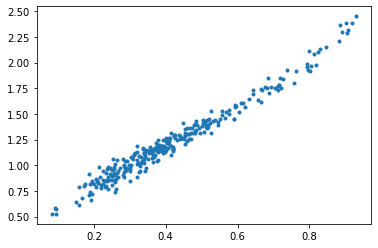

In [28]:
plt.plot(df_res2['pred'], df_res2['win_pcg'], '.')

In [29]:
pyth_lm2 = smf.ols(formula='win_pcg ~ pred', data=df_res2).fit()
pyth_lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                win_pcg   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     9497.
Date:                Thu, 18 Aug 2022   Prob (F-statistic):          1.67e-227
Time:                        19:11:02   Log-Likelihood:                 397.00
No. Observations:                 299   AIC:                            -790.0
Df Residuals:                     297   BIC:                            -782.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3881      0.009     41.184      0.000       0.370       0.407
pred           2.0143      0.021     97.450      0.000       1.974       2.055
==============================================================================
Omnibus:                        3.602   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.165   Jarque-Bera (JB):                3.281
Skew:                           0.228   Prob(JB):                        0.194
Kurtosis:                       3.235   Cond. No.                         6.56
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dans le cas où on considère une victoire comme trois points, comme il est en habituel dans les compétitions de football sous formes de poules ou de championnat, le coefficient de détermination est encore plus important, avec une p-value quasiment nulle à nouveau. Cela signifie que ce modèle est probablement encore plus robuste que le premier. Ainsi, nous avons démontré empiriquement la relation reliant le nombre de points gagnés par une équipe, le nombre de buts qu'elle marque et le nombre de buts qu'elle encaisse : la pythagorean expectation fonctionne également pour le football.